In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
import torch  # Assuming torch is installed to check for GPU availability

Number of Ground Truth Frames: 986
Number of Prediction Frames: 986
Average Overlap: 0.11098121418699018
Average DIoU: -0.4931274276380353
Average CIoU: -0.49335668071175315
Average GIoU: -1.3264020987234921


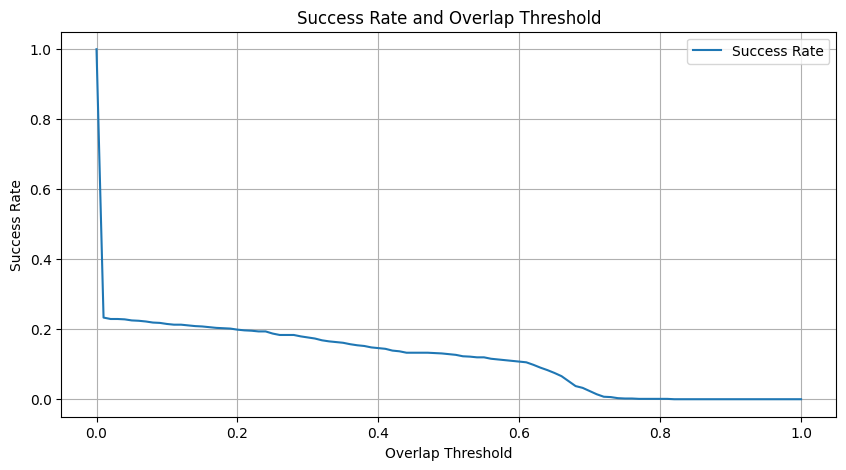

MAE: 0.11499843306288034


ZeroDivisionError: float division by zero

In [3]:
def load_coordinates(file_path):
    # Загрузка координат из файла
    coords = []
    with open(file_path, 'r') as file:
        for line in file:
            values = line.strip().split(' ')
            if len(values) == 5:  # Проверяем, что строка содержит индекс и 4 значения координат
                _, x, y, w, h = values  # Игнорируем первый элемент
                coords.append((float(x), float(y), float(w), float(h)))
            else:
                print(f"Warning: Incorrect format in line: {line.strip()}")
    return np.array(coords)

def main():
    ground_truth_file = './video/girl_dance_VIT1.txt'
    predicted_file = './video/girl_dance_VIT2.txt'
    ground_truth_coords = load_coordinates(ground_truth_file)
    predicted_coords = load_coordinates(predicted_file)
    
    num_ground_truth_frames = len(ground_truth_coords)
    num_predictions_frames = len(predicted_coords)
    print(f"Number of Ground Truth Frames: {num_ground_truth_frames}")
    print(f"Number of Prediction Frames: {num_predictions_frames}")

    # Проверка на совпадение количества кадров
    if num_ground_truth_frames != num_predictions_frames:
        print("Warning: the number of frames in the ground truth and predicted files do not match")
        min_frames = min(num_ground_truth_frames, num_predictions_frames)
        ground_truth_coords = ground_truth_coords[:min_frames]
        predicted_coords = predicted_coords[:min_frames]
        print(f"Using first {min_frames} frames for comparison")
    total_frames = len(ground_truth_coords)
    
    # Вычисление IoU для каждого кадра
    ious = [calculate_iou(ground_truth_coords[i], predicted_coords[i]) for i in range(total_frames)]
    dious = [calculate_diou(ground_truth_coords[i], predicted_coords[i]) for i in range(total_frames)]
    cious = [calculate_ciou(ground_truth_coords[i], predicted_coords[i]) for i in range(total_frames)]
    gious = [calculate_giou(ground_truth_coords[i], predicted_coords[i]) for i in range(total_frames)]

    ao = np.mean(ious)
    print(f"Average Overlap: {ao}")

    ado = np.mean(dious)
    print(f"Average DIoU: {ado}")

    aco = np.mean(cious)
    print(f"Average CIoU: {aco}")

    ago = np.mean(gious)
    print(f"Average GIoU: {ago}")
    
    # Вычисление коэффициента успеха для диапазона порогов
    thresholds = np.linspace(0, 1, 101)
    success_rates = calculate_sr(ious, thresholds)
    
    # Построение графика коэффициента успеха и порогов перекрытия
    plt.figure(figsize=(10, 5))
    plt.plot(thresholds, success_rates, label='Success Rate')
    plt.xlabel('Overlap Threshold')
    plt.ylabel('Success Rate')
    plt.title('Success Rate and Overlap Threshold')
    plt.legend()
    plt.grid(True)
    plt.savefig('success_rate_and_threshold.png')
    plt.show()
    
    # Вычисление MAE
    mae = calculate_mae(ground_truth_coords, predicted_coords)
    print(f"MAE: {mae}")
    
    # Определение доступности GPU
    if torch.cuda.is_available():
        hardware = "GPU"
    else:
        hardware = "CPU"
    
    # Измерение FPS при чтении видео
    video_file = './video/girl_dance_VIT2.mp4'
    vid = cv2.VideoCapture(video_file)
    
    start_time = time.time()
    frame_count = 0
    while True:
        ret, frame = vid.read()
        if not ret:
            break
        frame_count += 1
    end_time = time.time()
    
    fps = frame_count / (end_time - start_time)
    print(f"FPS: {fps} ({hardware})")
    
    # Вычисление пропущенных кадров
    skipped_frames = total_frames - frame_count
    print(f"Skipped Frames: {skipped_frames}")

    # Запись метрик в текстовый файл
    with open('metrics_output.txt', 'w') as file:
        file.write(f"Average Overlap: {ao}\n")
        file.write(f"Average DIoU: {ado}\n")
        file.write(f"Average CIoU: {aco}\n")
        file.write(f"Average GIoU: {ago}\n")
        file.write(f"Mean Absolute Error: {mae}\n")
        file.write(f"FPS: {fps} ({hardware})\n")
        file.write(f"Skipped Frames: {skipped_frames}\n")
        file.write(f"Number of frames per second: {fps} ({hardware})\n")

if __name__ == "__main__":
    main()


Number of Ground Truth Frames: 986
Number of Prediction Frames: 986
Average Overlap: 0.09724467656973193
Average DIoU: -0.2814639889670952
Average CIoU: -0.2815896852296153
Average GIoU: -0.5978465840777031


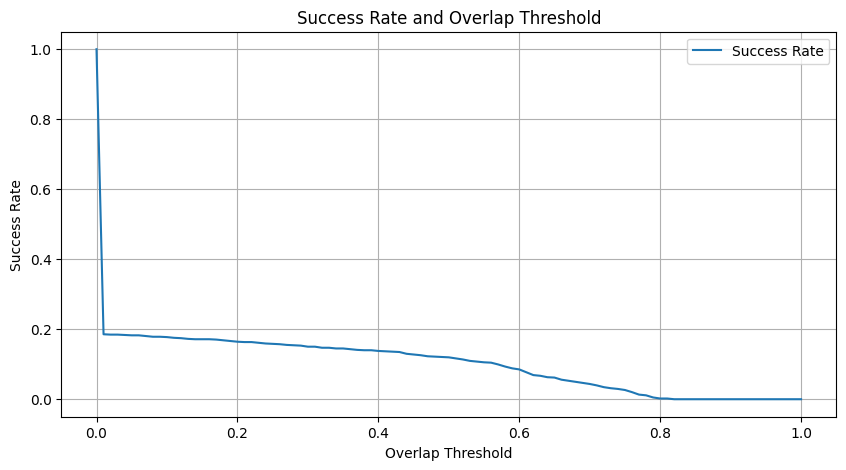

MAE: 0.09235192723123732


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def load_coordinates(file_path):
    coords = []
    with open(file_path, 'r') as file:
        for line in file:
            values = line.strip().split(' ')
            if len(values) == 5:
                _, x, y, w, h = values
                coords.append((float(x), float(y), float(w), float(h)))
            else:
                print(f"Warning: Incorrect format in line: {line.strip()}")
    return np.array(coords)

def calculate_iou(box1, box2):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2

    xi1 = max(x1, x2)
    yi1 = max(y1, y2)
    xi2 = min(x1 + w1, x2 + w2)
    yi2 = min(y1 + h1, y2 + h2)

    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)

    box1_area = w1 * h1
    box2_area = w2 * h2

    union_area = box1_area + box2_area - inter_area

    iou = inter_area / union_area
    return iou

def calculate_diou(box1, box2):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2

    # Центры прямоугольников
    cx1, cy1 = x1 + w1 / 2, y1 + h1 / 2
    cx2, cy2 = x2 + w2 / 2, y2 + h2 / 2

    # Расстояние между центрами
    center_distance = np.sqrt((cx2 - cx1) ** 2 + (cy2 - cy1) ** 2)

    # Диагональ минимального прямоугольника, включающего оба прямоугольника
    enclosing_x1 = min(x1, x2)
    enclosing_y1 = min(y1, y2)
    enclosing_x2 = max(x1 + w1, x2 + w2)
    enclosing_y2 = max(y1 + h1, y2 + h2)
    diagonal_distance = np.sqrt((enclosing_x2 - enclosing_x1) ** 2 + (enclosing_y2 - enclosing_y1) ** 2)

    iou = calculate_iou(box1, box2)
    diou = iou - (center_distance ** 2 / diagonal_distance ** 2)
    return diou

def calculate_ciou(box1, box2):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2

    iou = calculate_iou(box1, box2)
    diou = calculate_diou(box1, box2)

    v = (4 / (np.pi ** 2)) * (np.arctan(w1 / h1) - np.arctan(w2 / h2)) ** 2
    alpha = v / (1 - iou + v)

    ciou = diou - alpha * v
    return ciou

def calculate_giou(box1, box2):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2

    inter_area = calculate_iou(box1, box2) * (w1 * h1 + w2 * h2)  # Intersect area
    
    enclosing_x1 = min(x1, x2)
    enclosing_y1 = min(y1, y2)
    enclosing_x2 = max(x1 + w1, x2 + w2)
    enclosing_y2 = max(y1 + h1, y2 + h2)

    enclosing_area = (enclosing_x2 - enclosing_x1) * (enclosing_y2 - enclosing_y1)

    giou = calculate_iou(box1, box2) - (enclosing_area - (w1 * h1 + w2 * h2 - inter_area)) / enclosing_area
    return giou

def calculate_sr(ious, thresholds):
    success_rates = [(ious >= t).mean() for t in thresholds]
    return success_rates

def calculate_mae(ground_truth_coords, predicted_coords):
    mae = np.mean(np.abs(ground_truth_coords - predicted_coords))
    return mae

def main():
    ground_truth_file = './video/girl_dance_nanotreackerv2.txt'
    predicted_file = './video/girl_dance_VIT2.txt'
    ground_truth_coords = load_coordinates(ground_truth_file)
    predicted_coords = load_coordinates(predicted_file)
    
    num_ground_truth_frames = len(ground_truth_coords)
    num_predictions_frames = len(predicted_coords)
    print(f"Number of Ground Truth Frames: {num_ground_truth_frames}")
    print(f"Number of Prediction Frames: {num_predictions_frames}")

    if num_ground_truth_frames != num_predictions_frames:
        print("Warning: the number of frames in the ground truth and predicted files do not match")
        min_frames = min(num_ground_truth_frames, num_predictions_frames)
        ground_truth_coords = ground_truth_coords[:min_frames]
        predicted_coords = predicted_coords[:min_frames]
        print(f"Using first {min_frames} frames for comparison")
    total_frames = len(ground_truth_coords)

    ious = [calculate_iou(ground_truth_coords[i], predicted_coords[i]) for i in range(total_frames)]
    dious = [calculate_diou(ground_truth_coords[i], predicted_coords[i]) for i in range(total_frames)]
    cious = [calculate_ciou(ground_truth_coords[i], predicted_coords[i]) for i in range(total_frames)]
    gious = [calculate_giou(ground_truth_coords[i], predicted_coords[i]) for i in range(total_frames)]

    ao = np.mean(ious)
    print(f"Average Overlap: {ao}")

    ado = np.mean(dious)
    print(f"Average DIoU: {ado}")

    aco = np.mean(cious)
    print(f"Average CIoU: {aco}")

    ago = np.mean(gious)
    print(f"Average GIoU: {ago}")
    
    thresholds = np.linspace(0, 1, 101)
    success_rates = calculate_sr(ious, thresholds)
    
    plt.figure(figsize=(10, 5))
    plt.plot(thresholds, success_rates, label='Success Rate')
    plt.xlabel('Overlap Threshold')
    plt.ylabel('Success Rate')
    plt.title('Success Rate and Overlap Threshold')
    plt.legend()
    plt.grid(True)
    plt.savefig('success_rate_and_threshold.png')
    plt.show()
    
    mae = calculate_mae(ground_truth_coords, predicted_coords)
    print(f"MAE: {mae}")
    
    if torch.cuda.is_available():
        hardware = "GPU"
    else:
        hardware = "CPU"

    with open('metrics_output.txt', 'w') as file:
        file.write(f"Average Overlap: {ao}\n")
        file.write(f"Average DIoU: {ado}\n")
        file.write(f"Average CIoU: {aco}\n")
        file.write(f"Average GIoU: {ago}\n")
        file.write(f"Mean Absolute Error: {mae}\n")

if __name__ == "__main__":
    main()
